## Comandos úteis

# Adapted from:
# Image Classification Tutorial with the MedNIST Dataset

Introduction
<br />In this tutorial, we introduce an end-to-end training and evaluation example based on the MedNIST dataset.
We'll go through the following steps:

- Create a MONAI Dataset for training and testing
- Use MONAI transforms to pre-process data
- Use the DenseNet from MONAI for the classification task
- Train the model with a PyTorch program
- Evaluate on test dataset

### Get the dataset
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic) under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). If you use the MedNIST dataset, please acknowledge the source, e.g.

https://github.com/Project-MONAI/tutorials/blob/master/2d_classification/mednist_tutorial.ipynb

## Preparação no notebook

Get the dataset

The following commands download and unzip the dataset (~60MB).

Alternative: https://reposlink.di.uminho.pt/uploads/8920e974b5709bd3deafe02d18076229.file.MedNIST.tar.gz
        

In [ ]:
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz -O MedNIST.tar.gz

In [3]:
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

In [ ]:
!pip install gdown
!gdown --id 1Jx7yczBq2KRl48Af70iVxLf_8vuEVZ-V
!gdown --id 1jhWL1GL1Pp58fV2HrdAqliPHUST2mY9t

Usar o Cuda

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Instalações

In [ ]:
!pip3 -q install torch torchvision torchaudio
!pip -q install torchinfo
!pip -q install livelossplot
!pip -q install pandas
!pip -q install numpy
#!pip -q install monai
#print(monai.__file__)
!pip -q install matplotlib

In [1]:
import os
import time
import numpy as np
# para incluir os gráficos no nb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from monai.transforms import Compose, LoadImage, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc
from monai.utils import set_determinism
from monai.config import print_config
# from monai.metrics import occlusion_sensitivity

from torchinfo import summary
from livelossplot import PlotLosses

np.random.seed(0)
set_determinism(seed=0)
print_config()

c:\Programas_Universidade\PythonVenv\imag3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: c:\Programas_Universidade\PythonVenv\imag3\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.19.3
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit

Imports

In [2]:
# Constants
DATA_DIR = './MedNIST/'

BATCH_SIZE = 300

In [3]:
device = torch.device("cuda")


## Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [4]:
# conta os ficheiros do dataset por label
def file_list(dir_path):
    class_names = sorted([x for x in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, x))])
    num_class = len(class_names)
    image_files = [[os.path.join(dir_path, class_name, x) 
                    for x in os.listdir(os.path.join(dir_path, class_name))] 
                   for class_name in class_names] # constrói uma lista de listas de ficheiros por diretoria de classe
    image_file_list = list()
    image_label_list = list()
    for i, class_name in enumerate(class_names): # para juntar as listas e construir a lista com os labels em numérico
        image_file_list.extend(image_files[i])
        image_label_list.extend([i] * len(image_files[i]))
    return image_file_list, image_label_list, class_names

image_file_list, image_label_list, class_names = file_list(DATA_DIR)
print('Total image count:', len(image_label_list))
image_width, image_height = Image.open(image_file_list[0]).size
print("Image dimensions:", image_width, "x", image_height)
labels_cout= [image_label_list.count(x) for x in set(image_label_list)]
for i,label in enumerate(class_names):
    print(f"Label: {label:11}  {labels_cout[i]:5d} cases")

Total image count: 58954
Image dimensions: 64 x 64
Label: AbdomenCT    10000 cases
Label: BreastMRI     8954 cases
Label: CXR          10000 cases
Label: ChestCT      10000 cases
Label: Hand         10000 cases
Label: HeadCT       10000 cases


## Visualise some randomly picked examples from the dataset

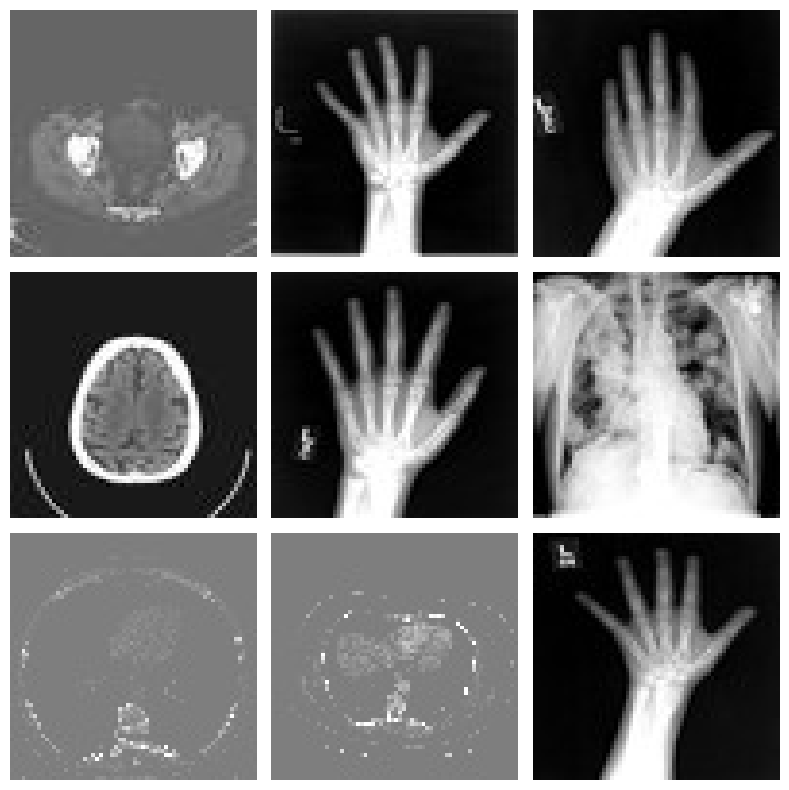

In [5]:
def visualize_sample_images(image_file_list,image_label_list,class_names):
    plt.subplots(3, 3, figsize=(8, 8))
    for i,k in enumerate(np.random.randint(len(image_label_list), size=9)):
        im = Image.open(image_file_list[k])
        arr = np.array(im)
        plt.subplot(3, 3, i + 1)
        plt.axis('off')
        # plt.grid(b=None)
        plt.xlabel(class_names[image_label_list[k]])
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()
    
visualize_sample_images(image_file_list,image_label_list,class_names)

## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test.

In [6]:
# separar a lista de ficheiros em 3 partes para treino, validação e teste
def holdout_dataset(image_file_list,image_label_list):
    valid_frac, test_frac = 0.1, 0.1
    trainX, trainY = list(), list()
    valX, valY = list(), list()
    testX, testY = list(), list()
    for i in range(len(image_label_list)):
        rann = np.random.random()
        if rann < valid_frac:
            valX.append(image_file_list[i])
            valY.append(image_label_list[i])
        elif rann < test_frac + valid_frac:
            testX.append(image_file_list[i])
            testY.append(image_label_list[i])
        else:
            trainX.append(image_file_list[i])
            trainY.append(image_label_list[i])
    return trainX, trainY, valX, valY, testX, testY

trainX, trainY, valX, valY, testX, testY = holdout_dataset(image_file_list,image_label_list)

print("Training count =",len(trainX))
print("Validation count =", len(valX))
print("Test count =",len(testX))

Training count = 47156
Validation count = 5913
Test count = 5885


-----------------------------------casos_treino-----------------------------------
casos: 47156
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
['0', '1', '2', '3', '4', '5']
[8039 7116 8045 8008 7951 7997]
47156


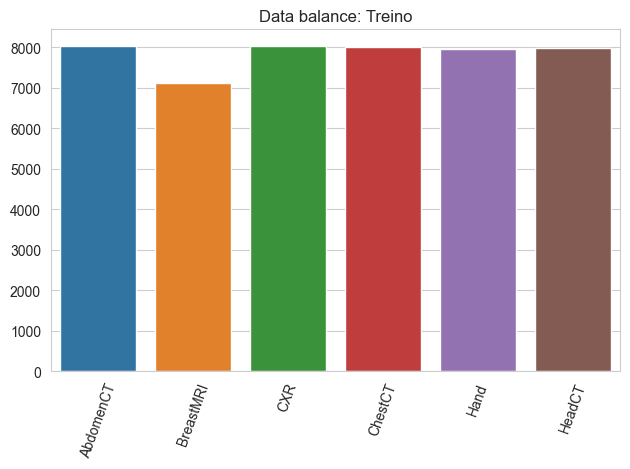

-----------------------------------casos_validação-----------------------------------
casos: 5913
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
['0', '1', '2', '3', '4', '5']
[ 992  894  982 1033  994 1018]
5913


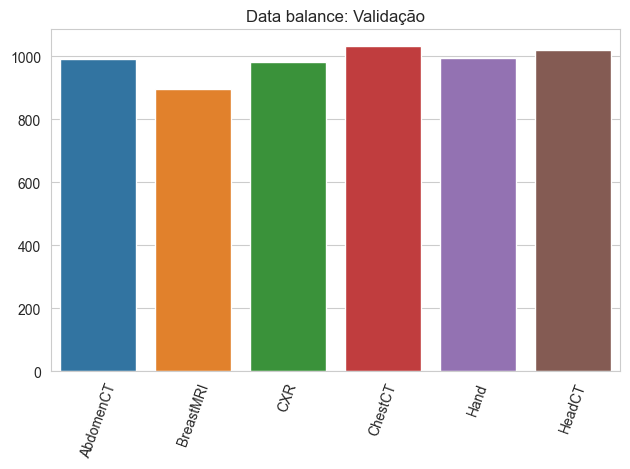

-----------------------------------casos_teste-----------------------------------
casos: 5885
['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
['0', '1', '2', '3', '4', '5']
[ 969  944  973  959 1055  985]
5885


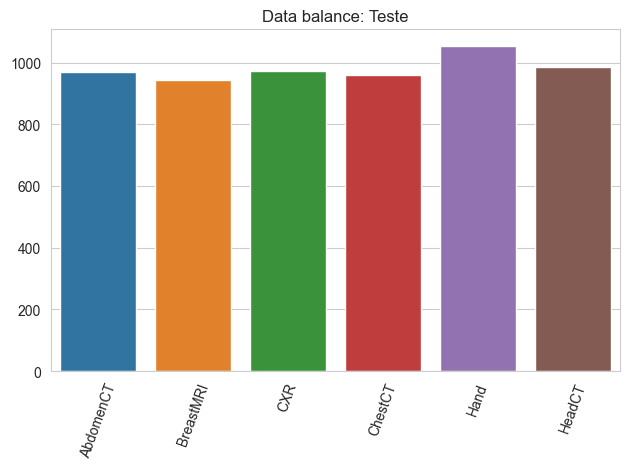

In [7]:
#verificar o balanceamento dos dados
def visualize_holdout_balance(labels, class_names, titulo):                          
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x_ext=[class_names[n]  for n in x]
    print(x_ext)
    print([str(n) for n in x])
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x_ext, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show() 
       
print("-----------------------------------casos_treino-----------------------------------")   
visualize_holdout_balance(trainY, class_names, 'Treino')
print("-----------------------------------casos_validação-----------------------------------")   
visualize_holdout_balance(valY, class_names, 'Validação')
print("-----------------------------------casos_teste-----------------------------------") 
visualize_holdout_balance(testY, class_names, 'Teste')

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [8]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True), #RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True), #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

c:\Programas_Universidade\PythonVenv\imag3\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [9]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
3. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
4. Use Adam optimizer.

In [10]:
model = densenet121(
                    spatial_dims=2,
                    in_channels=1,
                    out_channels=len(class_names)
                   ).to(device)

In [11]:
device = torch.device("cuda")
img=Image.open(trainX[0])
print(np.array(img).shape) # only one channel
print(summary(model, input_size=(BATCH_SIZE, 1,64,64), verbose=0))

(64, 64)


## Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [ ]:
def train_model(h5_file, train_dl, val_dl, model, loss_function, optimizer, epochs):
    liveloss = PlotLosses()
    best_metric = -1
    best_metric_epoch = -1
    #epoch_loss_values = list()
    metric_values = list()
    
    for epoch in range(epochs):
        logs = {}
        model.train()
        epoch_loss = 0
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
            #epoch_loss += loss.item()
            #epoch_len = len(train_ds) // train_loader.batch_size
        #epoch_loss_values.append(epoch_loss)
        #print("epoch %d average loss: %.4f"%(epoch + 1,epoch_loss ))
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        
        # Validation phase
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_images, val_labels in val_dl:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                outputs = model(val_images)
                loss = loss_function(outputs, val_labels)
                running_loss += loss.detach() * val_images.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == val_labels.data)
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            epoch_loss = running_loss / len(val_dl.dataset)
            epoch_acc = running_corrects.float() / len(val_dl.dataset)
            logs['val_loss'] = epoch_loss.item()
            logs['val_accuracy'] = epoch_acc.item()
            auc_metric = compute_roc_auc(y_pred, F.one_hot(y, num_classes=6), average="none")
            auc_metric_m = np.mean(auc_metric)
            metric_values.append(auc_metric_m)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric_m > best_metric:
                best_metric = auc_metric_m
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print("current epoch:%d current AUC:%.4f current accuracy:%.4f best AUC:%.4f at epoch:%d"%(epoch+1,auc_metric_m,acc_metric,best_metric,best_metric_epoch))
        logs['val_AUC'] = auc_metric_m
            
        liveloss.update(logs)
        liveloss.send()
    print("train completed, best_metric:%.4f at epoch: %d"%(best_metric,best_metric_epoch))

In [ ]:
#treino do modelo densenet121

EPOCHS = 4
LEARNING_RATE = 1e-5
loss_function = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
epoch_num = 4
val_interval = 1

device = torch.device("cuda")
starttime = time.perf_counter()
train_model('densenet121.pth', train_dl, val_dl, model, loss_function, optimizer, EPOCHS)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

In [ ]:
def get_rand_im():
    test_ds = MedNISTDataset(testX, testY, val_transforms)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=2, shuffle=True)
    itera = iter(test_loader)
    test_data = next(itera)  
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)

def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1,2, figsize=(13, 5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(np.squeeze(im.cpu()), cmap='gray')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [ ]:
device = torch.device("cuda")
# Get a random image and its corresponding label
im, label = get_rand_im()

Computing occlusion sensitivity: 100%|██████████| 4096/4096 [00:03<00:00, 1162.22it/s]


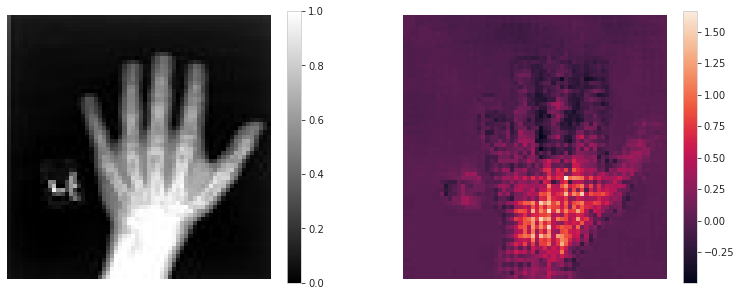

In [ ]:
# Get the occlusion sensitivity map
heatmap = occlusion_sensitivity.compute_occlusion_sensitivity(model, im, label, margin=2)

plot_occlusion_heatmap(im, heatmap)

As cores claras correspondem a valores mais elevados, sendo uma evidencia para a classificação correta da imagem — Quando existe oclusão das áreas mais claras a metrica de avaliação para a classe correta diminui. Neste caso o centro da mão fornece a maior evidencia na classificação da figura como pertencendo à classe mão.

As área mais escuras correspondem a valores mais baixos, sendo uma evidencia para a classificação incorreta da imagem — Quando existe oclusão das áreas mais escuras a metrica de avaliação para a classe correta aumenta. Frequentemente estas areas são evidencias de uma outra classe e podem confundir o modelo